# Imports

In [150]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

# Configs

In [151]:
INPUT_PATH = 'datasets/'
OUTPUT_PATH = 'results/predictions.parquet'

START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

FEATURE_LIST = ['Previous_week_demand', 'Previous_day_demand', 'Day_of_month', 'Day_of_week']

TEST_START_DATE = '2023-04-1'

AUTO_TUNE = False

# Data preparation


## Load Data

In [152]:
def load_data(path, start_date: str, end_date: str):
    df = pd.read_parquet(path)
    start_date = datetime.date.fromisoformat(start_date)
    end_date = datetime.date.fromisoformat(end_date)
    filtered_df = df[(df['tpep_pickup_datetime'].dt.date >= start_date) &
                     (df['tpep_pickup_datetime'].dt.date <= end_date)]
    dataset = filtered_df.filter(items=['tpep_pickup_datetime', 'PULocationID'])
    dataset['PU_date'] = pd.to_datetime(dataset['tpep_pickup_datetime'].dt.date)
    return dataset

In [153]:
rides_df = load_data(INPUT_PATH, START_DATE, END_DATE)

In [154]:
print(f'rides dataframe shape : {rides_df.shape}')
rides_df.head()

rides dataframe shape : (12672629, 3)


,tpep_pickup_datetime,PULocationID,PU_date
0,2023-01-01 00:32:10,161,2023-01-01
1,2023-01-01 00:55:08,43,2023-01-01
2,2023-01-01 00:25:04,48,2023-01-01
3,2023-01-01 00:03:48,138,2023-01-01
4,2023-01-01 00:10:29,107,2023-01-01


## Labeling

In [155]:
def labeling(dataset):
    dataset_labels = (
        dataset
        .groupby(['PULocationID', 'PU_date'])['PU_date']
        .count()
        .to_frame('Demand')
        .sort_values(['PULocationID', 'PU_date'], ascending=[True, True])
        .reset_index()
        .rename(columns={'PULocationID': 'Location', 'PU_date': 'Date'})
    )

    locations = pd.DataFrame(dataset_labels['Location'].unique(), columns=['Location'])
    dates = pd.DataFrame(dataset_labels['Date'].unique(), columns=['Date'])

    location_date_df = (
        locations
        .merge(dates, how='cross')
        .sort_values(['Location', 'Date'], ascending=[True, True])
        .reset_index(drop=True)
    )

    labels_df = (
        location_date_df
        .merge(dataset_labels, how='left', on=['Location', 'Date'])
        .fillna(value=0)
    )

    return labels_df


In [156]:
labeled_df = labeling(rides_df)

In [157]:
print(f'labeled dataframe shape : {labeled_df.shape}')
labeled_df.head()

labeled dataframe shape : (31440, 3)


,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


## Add Feature

In [158]:
def feature_engineering(dataset):
    dataset['Previous_day_demand'] = dataset.groupby(['Location'])['Demand'].shift(1)
    dataset['Previous_week_demand'] = dataset.groupby(['Location'])['Demand'].shift(7)
    dataset['Day_of_week'] = dataset['Date'].dt.dayofweek   
    dataset['Day_of_month'] = dataset['Date'].dt.day
    return dataset

In [159]:
features_df = feature_engineering(labeled_df)
features_df.dropna(inplace = True)

In [160]:
print(f'features dataframe shape : {features_df.shape}')
features_df.head()

features dataframe shape : (29606, 7)


,Location,Date,Demand,Previous_day_demand,Previous_week_demand,Day_of_week,Day_of_month
7,1,2023-01-08,12.0,6.0,40.0,6,8
8,1,2023-01-09,14.0,12.0,31.0,0,9
9,1,2023-01-10,4.0,14.0,27.0,1,10
10,1,2023-01-11,9.0,4.0,7.0,2,11
11,1,2023-01-12,8.0,9.0,15.0,3,12


## Split Train and Test Data

In [161]:
def train_test_splitting(dataset, TEST_START_DATE):

    train_df = dataset[dataset['Date'] < TEST_START_DATE]
    test_df = dataset[dataset['Date'] >= TEST_START_DATE]

    return train_df, test_df

In [162]:
train_df, test_df = train_test_splitting(features_df, TEST_START_DATE)

In [163]:
print(f'train dataframe shape : {train_df.shape}')
train_df.head()

train dataframe shape : (21746, 7)


,Location,Date,Demand,Previous_day_demand,Previous_week_demand,Day_of_week,Day_of_month
7,1,2023-01-08,12.0,6.0,40.0,6,8
8,1,2023-01-09,14.0,12.0,31.0,0,9
9,1,2023-01-10,4.0,14.0,27.0,1,10
10,1,2023-01-11,9.0,4.0,7.0,2,11
11,1,2023-01-12,8.0,9.0,15.0,3,12


In [164]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (7860, 7)


,Location,Date,Demand,Previous_day_demand,Previous_week_demand,Day_of_week,Day_of_month
90,1,2023-04-01,13.0,13.0,15.0,5,1
91,1,2023-04-02,17.0,13.0,14.0,6,2
92,1,2023-04-03,9.0,17.0,3.0,0,3
93,1,2023-04-04,12.0,9.0,14.0,1,4
94,1,2023-04-05,18.0,12.0,7.0,2,5


# Model Training

## **Gradient Boosting Regressor**

### Model Tuning

In [165]:
def grid_search(model, test_parameters, train_data, feature_list, cv = None):
    gs = GridSearchCV(
        estimator = model, 
        param_grid = test_parameters, 
        scoring = 'neg_root_mean_squared_error', 
        cv = cv, 
        n_jobs = -1
        )
    
    gs.fit(train_data[feature_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [166]:
if AUTO_TUNE:
    params_test = {'learning_rate':[0.1, 0.08, 0.06, 0.04, 0.02, 0.01], 
                'subsample':[0.8, 0.9, 1], 
                'colsample_bytree':[0.8, 0.9, 1], 
                'max_depth':range(2,10,1), 
                'gamma':[0, 1, 5]
                }
    params = {"objective": "reg:squarederror"}

    best_params, best_score = grid_search(
        model = xgb.XGBRegressor(**params), 
        test_parameters = params_test,
        train_data = train_df, 
        feature_list = FEATURE_LIST, 
        cv = 5
        )
    
    print(best_params, best_score)
else:
    best_params = {'colsample_bytree': 0.8, 
                   'gamma': 0, 
                   'learning_rate': 0.08, 
                   'max_depth': 3, 
                   'subsample': 0.8, 
                   'n_estimators': 1000
                   }

### Prediction

In [167]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])
    
    train_predict_df  = model.predict(train_data[feature_list])
    test_predict_df  = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [168]:
model = xgb.XGBRegressor(**best_params)
train_prediction_df, test_prediction_df = model_predict(model, train_df, test_df, FEATURE_LIST)

### Evaluation

In [183]:
def plot_cumsum_demand(labeled_df, target_demand):
    grouped_df = labeled_df.groupby('Location')['Demand'].sum().reset_index().sort_values(by='Demand', ascending=False)
    cumulative_demand = (grouped_df['Demand'].cumsum() / grouped_df['Demand'].sum()).to_numpy()

    # Plot the cumulative demand for each location
    plt.plot(range(1,263), cumulative_demand)
    plt.xlabel('Location')
    plt.ylabel('Cumulative Demand')
    plt.title('Cumulative Demand by Location')
    target_x = (cumulative_demand <= target_demand).argmin()
    plt.axhline(y=target_demand, color='r', linestyle='--', label=f'Target Demand ({target_demand})')
    plt.axvline(x=target_x, color='g', linestyle='--', label=f'Target Location ({target_x})')

    plt.legend()  # Show the label of the horizontal line
    plt.show()
    important_locations = grouped_df.iloc[:target_x, grouped_df.columns.get_loc('Location')]
    important_locations = important_locations.to_numpy()
    return important_locations

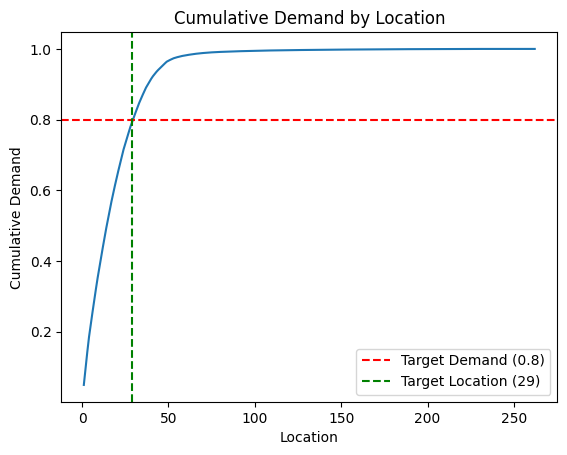

In [223]:
important_locations = plot_cumsum_demand(labeled_df, 0.8)

In [171]:
def evaluate(metric, metric_name, df_true, df_pred, important_locations):
    selected_df_true = df_true[df_true['Location'].isin(important_locations)]['Demand'].to_numpy()
    selected_df_pred = df_pred[df_pred['Location'].isin(important_locations)]['Predicted_demand'].to_numpy()

    print(f'{metric_name} : {metric(selected_df_true, selected_df_pred)}')

In [172]:
def prediction_labeling(pred_df, labeled_df):
    pred_df = pd.DataFrame(pred_df, columns = ['Predicted_demand'])
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['Location', 'Date']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [173]:
def evaluation(model_name, train_df, test_df, train_prediction_df, test_prediction_df, important_locations):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_df, train_prediction_df, important_locations)
    evaluate(mean_squared_error, 'MSE', train_df, train_prediction_df, important_locations)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_df, train_prediction_df, important_locations)

    print(f'{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_df, test_prediction_df, important_locations)
    evaluate(mean_squared_error, 'MSE', test_df, test_prediction_df, important_locations)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_df, test_prediction_df, important_locations)


In [174]:
labeled_train_prediction_df = prediction_labeling(train_prediction_df, train_df)
labeled_test_prediction_df = prediction_labeling(test_prediction_df, test_df)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [224]:
evaluation('XGB', train_df, test_df, labeled_train_prediction_df, labeled_test_prediction_df, important_locations)

XGB train scores:
MAE : 140.30477143284884
MSE : 37154.64754893344
MAPE : 0.055590815457526845
XGB test scores:
MAE : 253.27277958310884
MSE : 116578.25883828371
MAPE : 0.08873248696514606


### Visualization

In [176]:
def add_day_of_year(data):
    data['day_year'] = 0
    start_date = data['Date'].min()

    for index, row in data.iterrows():

        curr_date = row['Date']
        day_number = (curr_date - start_date).days

        data.at[index, 'day_year'] = day_number
    return data

In [177]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df, important_locations):

    train_data = train_data[train_data['Location'].isin(important_locations)]
    test_data = test_data[test_data['Location'].isin(important_locations)]

    train_data = add_day_of_year(train_data)
    test_data = add_day_of_year(test_data)

    predicted_train_df = add_day_of_year(train_prediction_df)
    predicted_test_df = add_day_of_year(test_prediction_df)

    train_data = train_data.groupby('day_year')['Demand'].sum()
    test_data = test_data.groupby('day_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('day_year')['Predicted_demand'].sum()
    predicted_test_df = predicted_test_df.groupby('day_year')['Predicted_demand'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Train actual Value", "Predicted"], loc ="lower right")
    plt.show()

    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Test actual Value", "Predicted"], loc ="lower right")
    plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


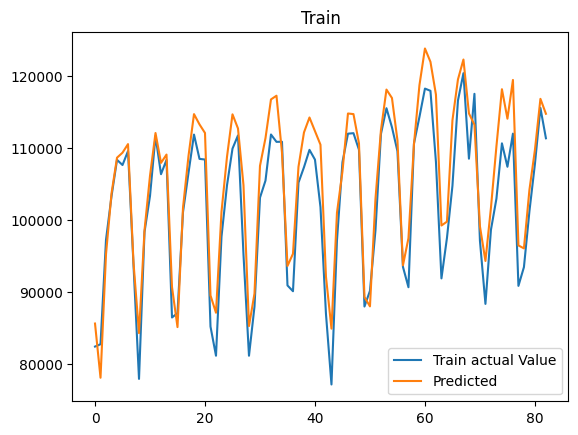

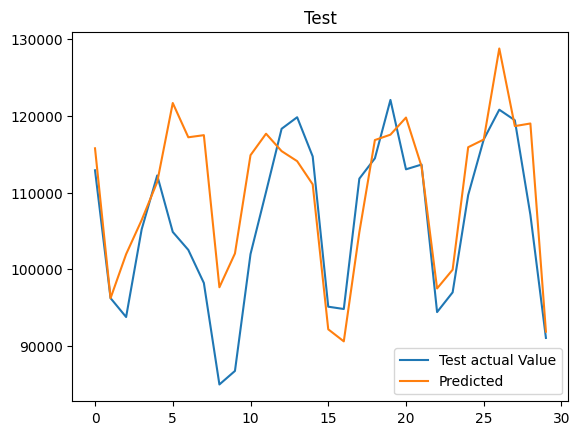

In [186]:
prediction_visualization(train_df, test_df, labeled_train_prediction_df, labeled_test_prediction_df, important_locations)

In [221]:
def prediction_visualization_for_location(train_df, test_df, train_prediction_df, test_prediction_df, important_locations):

    train_df = add_day_of_year(train_df)
    test_df = add_day_of_year(test_df)

    fig, axes = plt.subplots(nrows=len(important_locations) // 2 + 1, ncols=2, figsize=(10,100))
    for i, ax in enumerate(axes.flat):
        try:
            important_location = important_locations[i]
        except IndexError:
            continue
        location_train_df = train_df[train_df['Location'] == important_location]
        location_train_df_pred = train_prediction_df[train_prediction_df['Location'] == important_location]

        location_train_df = location_train_df.groupby('day_year')['Demand'].sum()
        location_train_df_pred = location_train_df_pred.groupby('day_year')['Predicted_demand'].sum()

        ax.plot(location_train_df, label = 'Train actual')
        ax.plot(location_train_df_pred, label = 'Train predicted')
        ax.set_title('Location ' + str(important_locations[i]))
        ax.legend()
    plt.show()


    fig, axes = plt.subplots(nrows=len(important_locations) // 2 + 1, ncols=2, figsize=(10,100))
    for i, ax in enumerate(axes.flat):
        try:
            important_location = important_locations[i]
        except IndexError:
            continue
        location_test_df = test_df[test_df['Location'] == important_location]
        location_test_df_pred = test_prediction_df[test_prediction_df['Location'] == important_location]

        location_test_df = location_test_df.groupby('day_year')['Demand'].sum()
        location_test_df_pred = location_test_df_pred.groupby('day_year')['Predicted_demand'].sum()

        ax.plot(location_test_df, label = 'Test actual')
        ax.plot(location_test_df_pred, label = 'Test predicted')
        ax.set_title('Location ' + str(important_locations[i]))
        ax.legend()
    plt.show()

In [ ]:
prediction_visualization_for_location(train_df, test_df, labeled_train_prediction_df, labeled_test_prediction_df, important_locations)

### Feature Importance and SHAPE

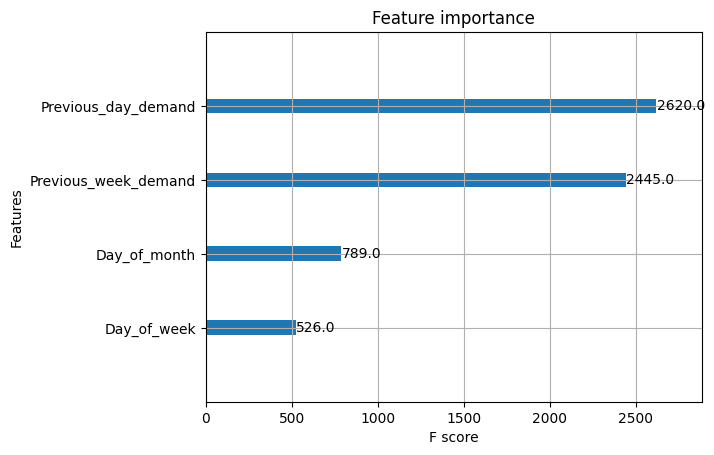

In [ ]:
xgb.plot_importance(model)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


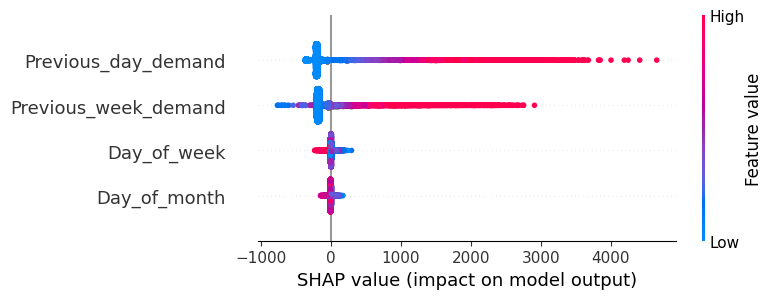

In [ ]:
dtrain_reg = xgb.DMatrix(train_df[FEATURE_LIST].values, train_df['Demand'].values, enable_categorical=True)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtrain_reg)
shap.summary_plot(shap_values, train_df[FEATURE_LIST])

# File Saving

In [ ]:
def save_predictions(dataset, path):
    output_df = dataset[['Location', 'Date', 'Predicted_demand']]
    output_df.to_parquet(path, index=False)
    return output_df

In [ ]:
output_df = save_predictions(labeled_test_prediction_df, OUTPUT_PATH)
print(f'output_df shape : {output_df.shape}')
output_df.head()

output_df shape : (7860, 3)


,Location,Date,Predicted_demand
0,1,2023-04-01,18.244568
1,1,2023-04-02,10.477506
2,1,2023-04-03,10.072111
3,1,2023-04-04,12.195824
4,1,2023-04-05,6.412234
